# Imports

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import GEOparse as Geo
import seaborn as sns
from pandas.core.ops import comp_method_OBJECT_ARRAY

# from sanbomics import annotate
os.getcwd()

'/home/max/mcrc-cetuximab-analysis/notebooks'

In [44]:
fpkms_df = pd.read_csv("../raw/GSE183984_ASAN_RNASEQ_FPKM_ensg.csv", index_col=0).T
raw_counts_df = pd.read_csv("../raw/GSE183984_ASAN_RNASEQ_raw_counts_ensg.csv", index_col=0).T

print(fpkms_df.shape)
print(raw_counts_df.shape)

# columns are the same in TPM and FPKM
print(set(fpkms_df.columns) - set(raw_counts_df.columns))
print(set(raw_counts_df.columns) - set(fpkms_df.columns))

# no duplicate column names
print(len(fpkms_df.columns), len(set(fpkms_df.columns)))
print(len(raw_counts_df.columns), len(set(raw_counts_df.columns)))

# no transcript level distinction
print(''.join(list(raw_counts_df.columns)).find('T')) 

ensembl_genes = list(fpkms_df.columns)

(113, 58735)
(113, 58735)
set()
set()
58735 58735
58735 58735
-1


In [46]:
def parse_gtf(gtf_path):
    lengths = Counter()
    version = dict()
    ensembl_to_hgnc = dict()
    with open(gtf_path, "r") as f:
        for li, line in enumerate(f):
            # print(line)
            if line.startswith("#"):
                continue
            parts = line.strip().split()
            if len(parts) > 10:
                if parts[2] == 'exon':
                    cur_version = parts[11][1:-2]
                    gene = parts[9][1:-2]
                    version[gene] = cur_version
                    lengths[gene] += int(parts[4]) - int(parts[3]) + 1
                elif parts[2] == 'gene':
                    hgnc_name = parts[13][1:-2]
                    gene = parts[9][1:-2]
                    ensembl_to_hgnc[gene] = hgnc_name
    return ensembl_to_hgnc, lengths, version

# all ensemble genes lengths
ensembl_to_hgnc, ensemble_lengths, ensemble_version = parse_gtf('../data/Homo_sapiens.GRCh38.113.gtf')\

hgnc_to_length = dict()
hgnc_to_last_version = dict()
hgnc_to_ensembl_of_last_version = dict()

In [ ]:
from collections import Counter

cnt = Counter()
hgnc_to_ensembl_set = dict()
for key in ensembl_genes:
    cnt[ensebml_to_hgnc[key]] += 1
    if cnt[ensebml_to_hgnc[key]] == 1:
        hgnc_to_ensembl_set[ensebml_to_hgnc[key]] = {key}
    else:
        hgnc_to_ensembl_set[ensebml_to_hgnc[key]].add(key)



del hgnc_to_ensembl[None]

hgnc_gene_lengths = {gene: ensembl_gene_lengths[hgnc_to_ensembl[gene]] for gene in hgnc_to_ensembl}

for key in hgnc_to_ensembl_set:
    if len(hgnc_to_ensembl_set[key]) > 1 and key is not None:
        print(key)
        print([(egene, ensembl_gene_lengths[egene]) for egene in hgnc_to_ensembl_set[key]])

# Examine raw counts/FPKM data

(113, 58735)
(113, 58735)
set()
set()
58735 58735
58735 58735
-1


# Rename columns and shrink gene list to those that are in BG list

In [3]:
from time import time
import mygene

mg = mygene.MyGeneInfo()

# Example list of Ensembl gene IDs
ensembl_ids = raw_counts_df.columns

t1 = time()
# Query
result = mg.querymany(ensembl_ids, scopes="ensembl.gene", fields="symbol", species="human")
t2 = time()
print(t2-t1)


# Convert to dict: {ensembl_id: gene_symbol}
ensembl_to_hgnc = {item['query']: item.get('symbol', None) for item in result}

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
31 input query terms found dup hits:	[('ENSG00000188660', 2), ('ENSG00000215156', 2), ('ENSG00000226506', 2), ('ENSG00000226519', 2), ('E
1383 input query terms found no hit:	['ENSG00000112096', 'ENSG00000116883', 'ENSG00000130489', 'ENSG00000130723', 'ENSG00000131484', 'ENS


127.98343515396118


In [6]:

print('Total genes: ', len(ensembl_to_hgnc))
print('Genes could convert: ', sum(ensebml_to_hgnc[k] != None for k in ensebml_to_hgnc))

# renaming to new names
raw_counts_df = raw_counts_df.rename(columns=ensebml_to_hgnc)
fpkms_df = fpkms_df.rename(columns=ensebml_to_hgnc)

# dropping cols that couldnt convert
raw_counts_df = raw_counts_df.drop(columns=[None])
fpkms_df = fpkms_df.drop(columns=[None])

print('With/without dup cols: ', len(fpkms_df.columns), len(set(fpkms_df.columns)))

# deduplicating cols
raw_counts_df = raw_counts_df.loc[:, ~raw_counts_df.columns.duplicated()]
fpkms_df = fpkms_df.loc[:, ~fpkms_df.columns.duplicated()]

Total genes:  58735
Genes could convert:  44446
With/without dup cols:  44446 43397


In [36]:
with open('../data/gnames.txt', 'r') as f:
    bg_genes = f.read().strip().split()
    print('BG list contains genes: ', len(bg_genes))

common_with_bg = set(raw_counts_df.columns).intersection(set(bg_genes))
print('Common genes in renamed data and BG list: ', len(common_with_bg))
gene_list = common_with_bg

BG list contains genes:  20062
Common genes in renamed data and BG list:  18366


In [38]:
# using only those in BG list
raw_counts_df = raw_counts_df[list(common_with_bg)]
fpkms_df = fpkms_df[list(common_with_bg)]
raw_counts_df.shape

(113, 18366)

# Get gene lengths

MATR3
[('ENSG00000015479', 41180), ('ENSG00000280987', 23097)]
SIGLEC5
[('ENSG00000268500', 5713), ('ENSG00000105501', 553)]
PDE4C
[('ENSG00000105650', 27984), ('ENSG00000285188', 5979)]
PDE8B
[('ENSG00000113231', 21876), ('ENSG00000284762', 3397)]
EMC3
[('ENSG00000125037', 11200), ('ENSG00000206567', 11291)]
SYNCRIP
[('ENSG00000135316', 86333), ('ENSG00000271793', 51714)]
AGAP11
[('ENSG00000261011', 1740), ('ENSG00000151303', 12078)]
C4orf36
[('ENSG00000285458', 3014), ('ENSG00000163633', 4881)]
ELFN2
[('ENSG00000166897', 11037), ('ENSG00000243902', 5718)]
SPATA13
[('ENSG00000228741', 1721), ('ENSG00000182957', 41488)]
ANKRD45
[('ENSG00000285777', 1786), ('ENSG00000183831', 4484)]
MGAT4EP
[('ENSG00000184774', 1135), ('ENSG00000228288', 17523)]
GOLGA6L3P
[('ENSG00000230373', 1828), ('ENSG00000188388', 1679)]
CLN3
[('ENSG00000188603', 82921), ('ENSG00000261832', 23795)]
GOLGA8M
[('ENSG00000188626', 5932), ('ENSG00000261480', 557)]
H1-9P
[('ENSG00000188662', 423), ('ENSG00000253730', 119

In [27]:
def counts_to_tpm(counts):
    gl_df = pd.Series(hgnc_gene_lengths)
    tpm = counts / (gl_df / 1000)
    tpm = (tpm.T / tpm.sum(axis=1)).T * 1_000_000
    print('Nans: ', tpm.isna().sum().sum())
    # print(tpm)
    return tpm

def counts_to_fpkm(counts):
    gl_df = pd.Series(hgnc_gene_lengths)
    fpkm = (counts.T / counts.sum(axis=1)).T * 1_000_000
    fpkm = fpkm / (gl_df / 1000)
    print('Nans: ', fpkm.isna().sum().sum())
    # print(tpm)
    return fpkm

def fpkm_to_tpm(fpkm):
    return (fpkm.T / fpkm.sum(axis=1)).T * 1_000_000

print(raw_counts_df.shape)

tpm_df = counts_to_tpm(raw_counts_df)
tpm_from_fpkm_df = fpkm_to_tpm(raw_counts_df)

fpkm_from_counts_df = counts_to_fpkm(raw_counts_df)


(113, 18366)
Nans:  0
Nans:  0


In [28]:
fpkm_from_counts_df

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
18R176_0020,0.109147,0.690879,33.945200,0.237857,0.000000,0.471027,0.000000,2.392853,1.572962,0.837810,...,2.574681,0.390268,2.773865,2.817923,1.539946,0.002375,2.404278,7.279917,5.163285,3.682679
18R177_0021,0.228629,1.309905,22.051434,0.000000,0.092707,0.691062,0.053311,1.344060,0.980846,1.122117,...,0.875555,1.216037,4.326643,4.898529,1.643027,0.135695,3.176770,2.369952,8.290772,2.512027
18R178_0022,0.073672,1.436078,34.932659,0.011853,0.000000,0.870593,0.000000,1.478917,0.938268,5.403503,...,3.087212,2.332362,7.577061,7.444066,2.614051,0.008089,2.975564,4.089724,6.629820,3.424983
18R296_0008,0.244878,0.608944,42.730983,0.075922,0.000000,0.334689,0.000000,1.344847,0.449498,0.011385,...,1.424104,0.675894,4.173468,5.432415,1.792889,0.006195,3.845877,3.448841,6.495687,6.060298
18R301_0002,0.059968,1.243647,60.558980,0.000000,0.026991,0.427966,0.000000,2.043139,1.001527,0.266200,...,1.527797,0.858288,2.503927,4.575729,2.226922,0.029630,2.370460,5.653169,4.292181,4.121681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18R309_0015,13.210052,4.569692,90.041935,0.001635,0.000000,0.038848,0.014465,1.228454,0.532073,16.384862,...,0.785771,1.102011,4.068180,5.549359,2.369083,0.119660,2.648021,4.925511,4.598893,3.336355
18R310_0016,13.058451,2.451979,189.496501,0.010761,0.000000,0.966021,0.253900,1.264865,0.319781,20.981147,...,0.654447,0.185994,3.406974,5.923299,1.263225,0.070686,2.247731,7.294640,3.691777,1.827539
18R311_0018,1.349050,1.156642,105.133406,0.000000,0.055227,0.656743,0.095273,1.529690,0.681611,1.782551,...,0.914001,0.486755,5.093154,6.615324,2.303864,0.006736,2.430501,6.259003,7.673123,2.527463
18R318_0005,0.188149,0.291173,80.007240,0.072089,0.000000,0.625416,0.151872,1.454510,1.093171,1.077404,...,0.777448,0.627582,2.973053,3.669988,1.470367,0.003221,3.000272,6.519377,6.095602,2.702405


In [29]:
fpkms_df

,KRT73,MEGF11,RDH16,COA1,RNF40,PER1,C9orf43,PALM3,DPF3,NEURL1,...,TMEM253,RNF208,KNDC1,RHPN2,TTR,OR2T10,SEMA6A,KLF5,CSH1,MAGEA2B
18R176_0020,0.000000,0.217140,0.006683,21.380620,22.652575,3.504540,1.532834,9.661206,1.384485,0.682435,...,0.265799,0.743327,0.000000,43.155971,1.436466,0.366425,30.980187,325.388442,0.0,10.481291
18R177_0021,0.090674,2.235795,0.054489,20.028843,45.450983,4.421108,0.721461,0.474382,2.423674,1.396259,...,1.279899,1.448458,0.253696,48.418352,1.729318,0.000000,59.973972,440.217246,0.0,0.000000
18R178_0022,0.000000,0.737270,0.000000,16.557018,27.087224,1.603047,0.466716,0.519399,0.125336,0.452570,...,0.661461,0.144139,0.040471,28.161412,0.000000,0.000000,14.513891,481.149625,0.0,0.000000
18R296_0008,0.612868,0.126085,0.000000,17.089332,24.696859,8.882027,0.274623,4.223234,0.913855,0.168041,...,0.337245,0.694841,0.000000,20.450263,0.031534,0.000000,20.110160,324.648316,0.0,0.000000
18R301_0002,0.000000,0.572444,0.000000,19.147960,18.404147,5.197192,0.023324,0.797448,0.388999,0.560601,...,0.000000,1.471461,0.322708,20.949205,5.904634,0.000000,49.720023,237.969094,0.0,3.987773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18R309_0015,0.010918,0.300017,10.992421,15.107334,25.268886,4.739587,0.564629,2.945586,1.855534,0.347862,...,0.428499,1.085807,0.195934,28.021407,1400.472567,0.000000,21.704951,597.519650,0.0,0.000000
18R310_0016,0.000000,0.565772,3.176938,16.755653,24.939122,6.847971,0.557005,2.083372,1.749755,0.534196,...,0.277121,1.434357,0.434723,20.269116,820.490794,0.184825,13.306509,506.276406,0.0,0.000000
18R311_0018,0.000000,2.339653,0.440859,7.766911,18.666888,1.554499,0.727649,0.578886,1.273861,0.597373,...,0.511760,1.375814,0.081542,14.400802,24.555377,0.000000,25.890588,593.240615,0.0,0.000000
18R318_0005,0.358251,0.588145,0.037930,11.550080,26.126156,9.423862,0.641805,4.885439,3.478098,0.072980,...,0.500176,0.387514,0.778802,34.287838,0.052191,0.352321,44.449087,489.518028,0.0,0.000000


In [30]:
tpm_df

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
18R176_0020,0.987749,6.252278,307.195134,2.152540,0.000000,4.262673,0.000000,21.654694,14.234897,7.581958,...,23.300188,3.531821,25.102748,25.501462,13.936110,0.021489,21.758083,65.881332,46.726373,33.327278
18R177_0021,3.151184,18.054394,303.934534,0.000000,1.277784,9.524896,0.734780,18.525152,13.518988,15.466120,...,12.067761,16.760617,59.634041,67.516337,22.645818,1.870285,43.785366,32.665011,114.271564,34.623227
18R178_0022,1.025917,19.997969,486.451451,0.165054,0.000000,12.123363,0.000000,20.594513,13.065764,75.245974,...,42.990680,32.479092,105.513643,103.661641,36.401718,0.112647,41.435937,56.951072,92.322938,47.694274
18R296_0008,2.210163,5.496063,385.671379,0.685240,0.000000,3.020755,0.000000,12.138009,4.056979,0.102755,...,12.853349,6.100323,37.667914,49.030628,16.181845,0.055917,34.711222,31.127747,58.627265,54.697633
18R301_0002,0.688680,14.282255,695.469882,0.000000,0.309973,4.914839,0.000000,23.463770,11.501714,3.057083,...,17.545491,9.856732,28.755536,52.548475,25.574358,0.340280,27.222781,64.921981,49.292156,47.334098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18R309_0015,168.419840,58.260697,1147.977908,0.020842,0.000000,0.495292,0.184419,15.662009,6.783589,208.896667,...,10.018079,14.049940,51.866731,70.750829,30.204314,1.525596,33.760598,62.797157,58.632990,42.536428
18R310_0016,111.123958,20.865695,1612.564972,0.091570,0.000000,8.220578,2.160623,10.763669,2.721251,178.543997,...,5.569173,1.582758,28.992446,50.405703,10.749714,0.601517,19.127596,62.075452,31.416041,15.551869
18R311_0018,18.491280,15.853970,1441.051883,0.000000,0.756987,9.001906,1.305898,20.967288,9.342761,24.433233,...,12.528116,6.671896,69.811288,90.675504,31.578805,0.092333,33.314611,85.791457,105.174644,34.643653
18R318_0005,1.358548,2.102440,577.700048,0.520527,0.000000,4.515879,1.096605,10.502429,7.893346,7.779502,...,5.613637,4.531518,21.467217,26.499506,10.616924,0.023261,21.663759,47.073794,44.013883,19.512977


In [31]:
tpm_from_fpkm_df

name,KRT73,MEGF11,RDH16,COA1,RNF40,PER1,C9orf43,PALM3,DPF3,NEURL1,...,TMEM253,RNF208,KNDC1,RHPN2,TTR,OR2T10,SEMA6A,KLF5,CSH1,MAGEA2B
18R176_0020,0.000000,1.413996,0.019915,22.862920,42.300385,4.500888,3.843679,26.925669,0.955941,0.856364,...,0.331592,0.916110,0.000000,97.864251,1.633066,0.438140,49.110070,417.367784,0.0,21.752834
18R177_0021,0.075872,2.465831,0.132776,14.605309,47.002540,2.958998,1.479499,1.081172,2.617575,2.693447,...,1.097674,1.460531,0.284519,65.553180,0.777685,0.000000,69.119151,473.306855,0.0,0.000000
18R178_0022,0.000000,0.898944,0.000000,13.891225,41.821407,2.917327,1.221207,1.509547,0.135690,1.034633,...,0.601614,0.186573,0.033922,74.018688,0.000000,0.000000,22.660167,658.366042,0.0,0.000000
18R296_0008,0.571565,0.831367,0.000000,12.444518,40.061476,10.106300,0.623525,10.651884,1.065188,0.831367,...,0.453095,0.779406,0.000000,33.514465,0.025980,0.000000,23.538066,396.328029,0.0,0.000000
18R301_0002,0.000000,1.104486,0.000000,18.141189,39.230529,6.212736,0.055224,2.098524,0.386570,1.546281,...,0.000000,1.711954,0.441795,47.272019,5.991839,0.000000,77.203324,280.898508,0.0,7.786077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18R309_0015,0.025733,0.205865,27.431530,13.664299,48.405328,4.786365,1.183725,6.870749,1.569722,0.334531,...,0.205865,1.106525,1.441056,56.381315,1240.311735,0.000000,25.810342,690.754744,0.0,0.000000
18R310_0016,0.000000,0.705763,7.283476,11.009906,36.502074,8.807925,1.072760,4.460424,1.326835,1.806754,...,0.169383,1.355065,2.314903,32.323956,675.641252,0.169383,16.062889,522.349479,0.0,0.000000
18R311_0018,0.000000,2.768352,1.242933,8.107316,40.478106,4.350267,1.723158,1.525418,1.468921,1.807903,...,0.482484,1.581915,0.677964,42.174710,24.180706,0.000000,42.739680,792.002859,0.0,0.000000
18R318_0005,0.442825,1.269845,0.108072,10.996320,29.053249,7.592054,1.540025,13.022669,1.675115,0.216144,...,0.297198,0.459306,1.567043,79.376947,0.054036,0.405270,52.225764,649.053042,0.0,0.000000


In [33]:
# should be sum 1 in every row
print((fpkm_from_counts_df * (pd.Series(hgnc_gene_lengths) / 1000)).sum(axis=1) / 10 ** 6)
print((fpkms_df * (pd.Series(hgnc_gene_lengths) / 1000)).sum(axis=1) / 10 ** 6)

18R176_0020    1.0
18R177_0021    1.0
18R178_0022    1.0
18R296_0008    1.0
18R301_0002    1.0
              ... 
18R309_0015    1.0
18R310_0016    1.0
18R311_0018    1.0
18R318_0005    1.0
18R319_0014    1.0
Length: 113, dtype: float64
18R176_0020    17.130031
18R177_0021    17.134469
18R178_0022    17.318845
18R296_0008    19.229072
18R301_0002    18.254296
                 ...    
18R309_0015    19.508759
18R310_0016    21.521936
18R311_0018    17.181563
18R318_0005    19.055971
18R319_0014    18.762945
Length: 113, dtype: float64


(0.0, 1000.0)

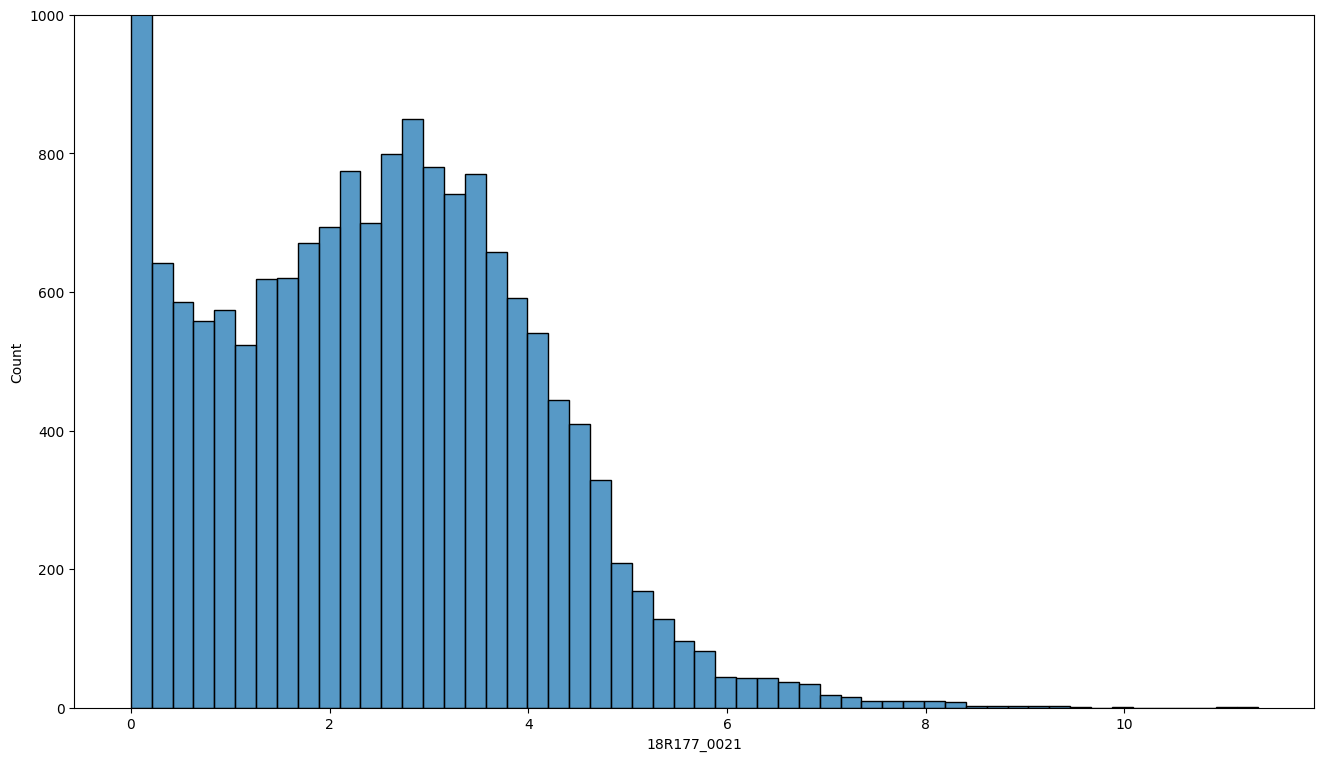

In [34]:
log_tpm_df = tpm_df.apply(lambda x: np.log(1 + x))
plt.figure(figsize=(16, 9))
sns.histplot(log_tpm_df.iloc[1])
plt.ylim(0, 1000)

(0.0, 1000.0)

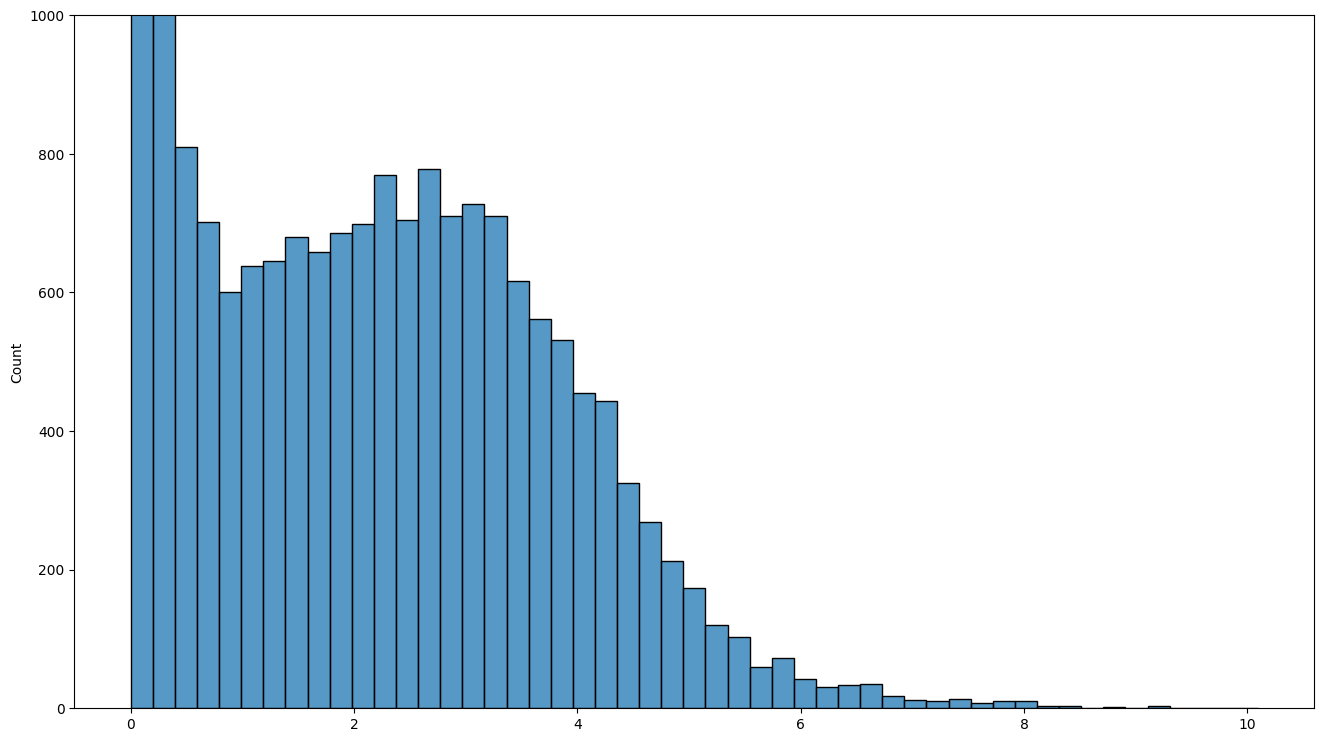

In [35]:
plt.figure(figsize=(16, 9))
sns.histplot(log_tpm_df.mean())
plt.ylim(0, 1000)